In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install alibi_detect

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Import Packages

In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Layer, Reshape, InputLayer
# from alibi_detect.models.losses import elbo
from alibi_detect.od import OutlierVAE
from alibi_detect.utils.visualize import plot_instance_score, plot_feature_outlier_image
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from glob import glob
from tqdm import tqdm

# Load Normal Images

- Negative: normal images
- Positive: crack images

In [4]:
img_list = glob('/content/drive/MyDrive/ABL/normal/*.jpg')

train_img_list, val_img_list = train_test_split(img_list, test_size=0.2, random_state=2021)

def img_to_np(fpaths, resize=True):  
    img_array = []
    for fname in tqdm(fpaths):
      try:
        img = Image.open(fname).convert('RGB')
        if(resize): img = img.resize((64, 64))
        img_array.append(np.asarray(img))
      except:
        continue
    images = np.array(img_array)
    return images

x_train = img_to_np(train_img_list)
x_train = x_train.astype(np.float32) / 255.

x_val = img_to_np(val_img_list)
x_val = x_val.astype(np.float32) / 255.

print(x_train.shape)
print(x_val.shape)

100%|██████████| 234/234 [00:00<00:00, 388.70it/s]

(936, 64, 64, 3)
(234, 64, 64, 3)


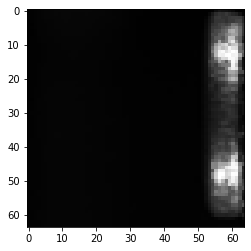

In [5]:
plt.imshow(x_train[1])

# Build Model

In [6]:
latent_dim = 1024

encoder_net = tf.keras.Sequential([
    InputLayer(input_shape=(64, 64, 3)),
    Conv2D(64, 4, strides=2, padding='same', activation=tf.nn.relu),
    Conv2D(128, 4, strides=2, padding='same', activation=tf.nn.relu),
    Conv2D(512, 4, strides=2, padding='same', activation=tf.nn.relu)
])

decoder_net = tf.keras.Sequential([
    InputLayer(input_shape=(latent_dim,)),
    Dense(4 * 4 * 128),
    Reshape(target_shape=(4, 4, 128)),
    Conv2DTranspose(256, 4, strides=2, padding='same', activation=tf.nn.relu),
    Conv2DTranspose(64, 4, strides=2, padding='same', activation=tf.nn.relu),
    Conv2DTranspose(32, 4, strides=2, padding='same', activation=tf.nn.relu),
    Conv2DTranspose(3, 4, strides=2, padding='same', activation='sigmoid')
])

od = OutlierVAE(
    threshold=.0035,
    score_type='mse',
    encoder_net=encoder_net,
    decoder_net=decoder_net,
    latent_dim=latent_dim,
)

# Train

In [7]:
od.fit(
    x_train,
    epochs=50,
    verbose=True
)

15/15 [=] - 1s 63ms/step - loss_ma: -23416.0903


# Reconstruct Training Image

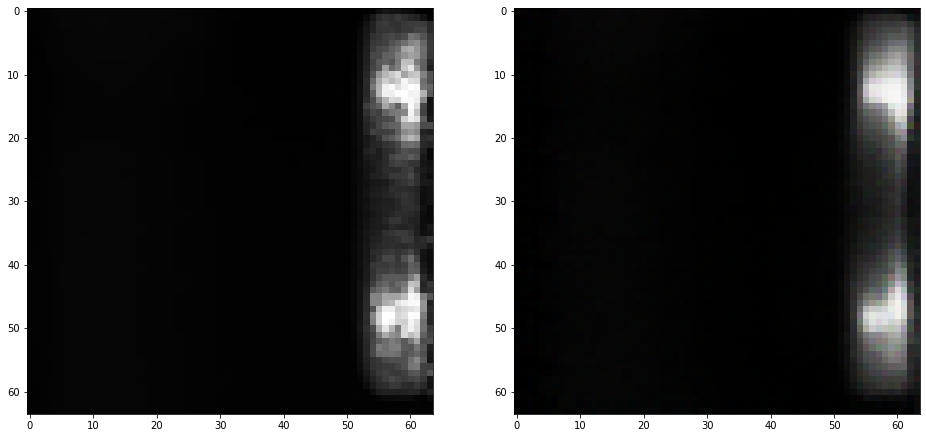

In [8]:
idx = 1
x = x_train[idx].reshape(1, 64, 64, 3)
x_recon = od.vae(x).numpy()

fig, axes = plt.subplots(1, 2, figsize=(16, 10))

axes[0].imshow(x.squeeze())
axes[1].imshow(x_recon.squeeze())

# Validation

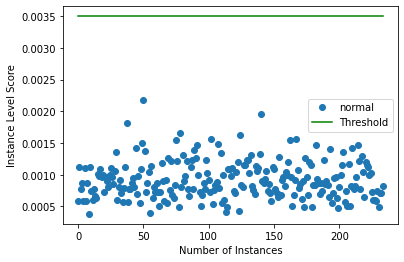

In [9]:
od_preds = od.predict(
    x_val,
    outlier_type='instance',
    return_feature_score=True,
    return_instance_score=True
)

target = np.zeros(x_val.shape[0],).astype(int)
labels = ['normal', 'outlier']
plot_instance_score(od_preds, target, labels, od.threshold)

# Reconstruct Validation Images

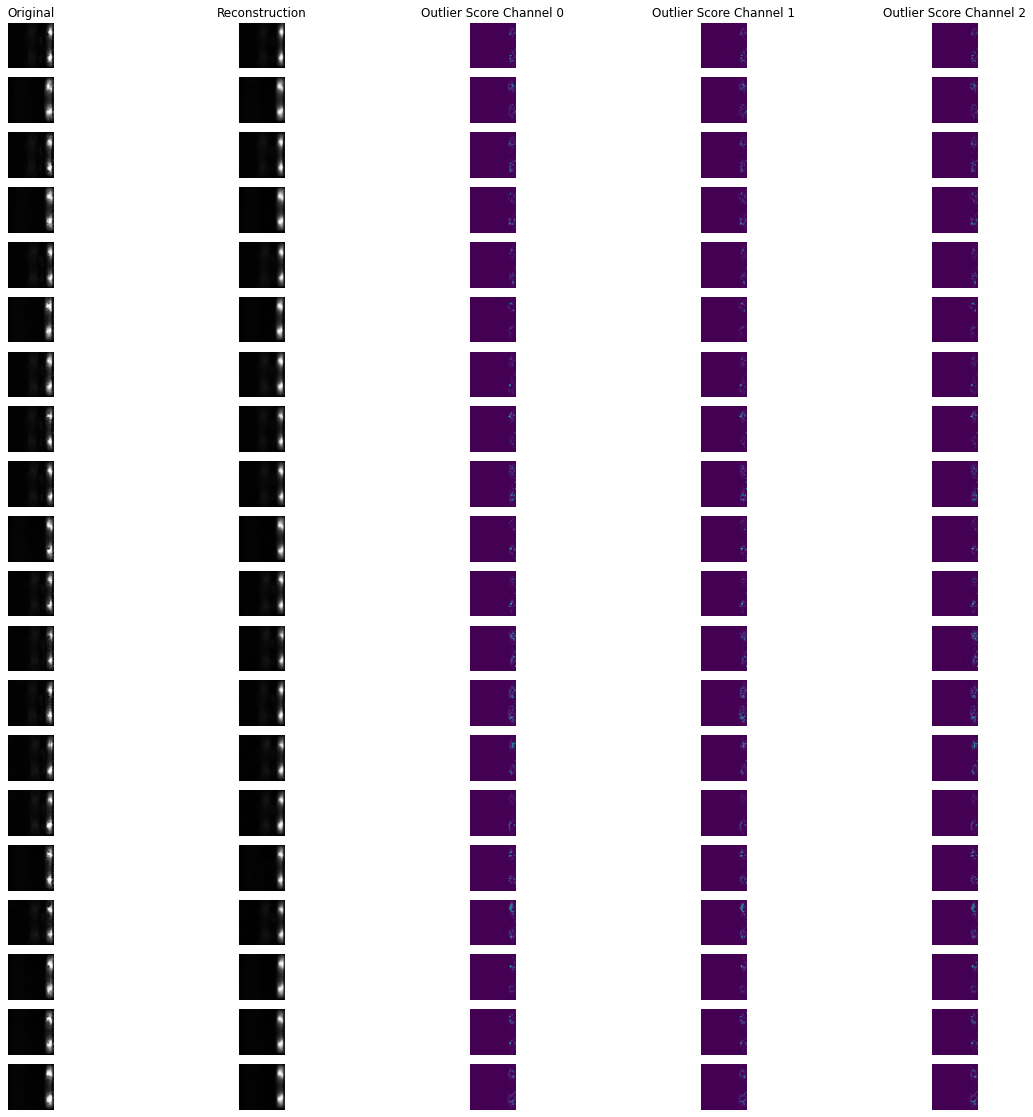

In [10]:
x_recon = od.vae(x_val).numpy()

plot_feature_outlier_image(
    od_preds,
    x_val,
    X_recon=x_recon,
    max_instances=20,
    outliers_only=False
)

# Outliers

In [11]:
plot_feature_outlier_image(
    od_preds,
    x_val,
    X_recon=x_recon,
    max_instances=20,
    outliers_only=True
)

<Figure size 1440x1440 with 0 Axes>

# Test with Crack Images

In [12]:
test_img_list = glob('/content/drive/MyDrive/ABL/unnormal/*.jpg')

x_test = img_to_np(test_img_list)
x_test = x_test.astype(np.float32) / 255.

print(x_test.shape)

100%|██████████| 356/356 [00:01<00:00, 312.31it/s]

(356, 64, 64, 3)


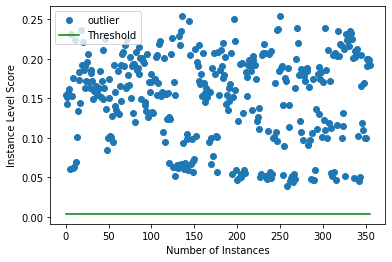

In [15]:
od_preds = od.predict(
    x_test,
    outlier_type='instance',
    return_feature_score=True,
    return_instance_score=True
)

target = np.zeros(x_test.shape[0],).astype(int)
labels = ['outlier', 'normal']
plot_instance_score(od_preds, target, labels, od.threshold)

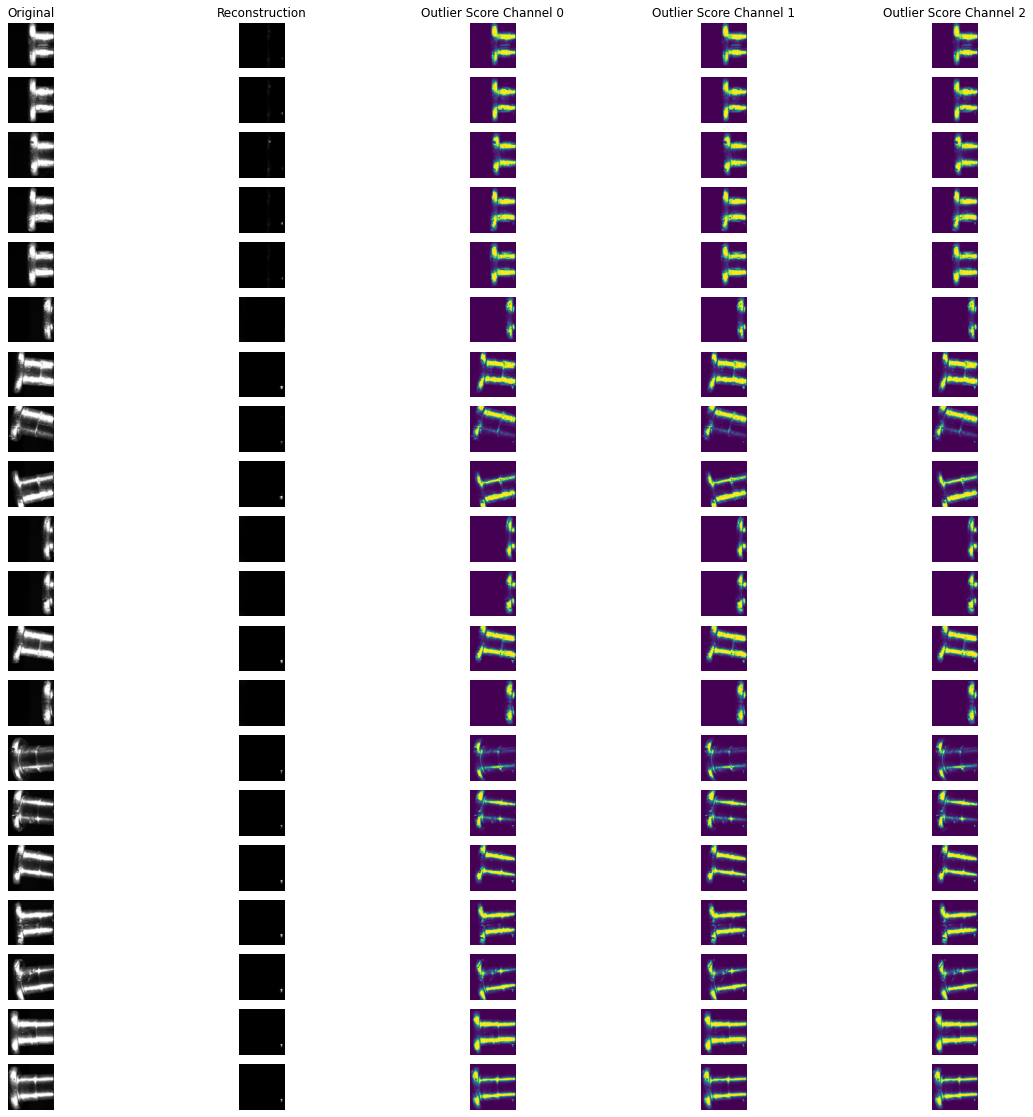

In [14]:
x_recon = od.vae(x_test).numpy()

plot_feature_outlier_image(
    od_preds,
    x_test,
    X_recon=x_recon,
    max_instances=20,
    outliers_only=False
)